# Siamese Network

Took inspiration from https://github.com/radekosmulski/whale/blob/master/siamese_network_prototype.ipynb
https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7

In [1]:
import fastai
from fastai import *
from fastai.vision import *
print(f'fastai version: {fastai.__version__}')
import torch
from torch import nn
print(f'torch version: {torch.__version__}')
torch.backends.cudnn.benchmark = True  # enable cudnn auto-tuner to find the best algorithm to use for your hardware.

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
# to stop fastai from printing out "UserWarning: Tensor is int32: upgrading to int64;"

verbose = True  # print out extra detail stuff

fastai version: 1.0.45
torch version: 1.0.0


In [2]:
# global setting
bs = 16
num_workers = 0
# num_workers = 0  # if using kaggle kernel or for fixing broken pipe error
sz = 224  # image size

data_fp = Path('data')
data_train = 'train'
data_test = 'test'
data_label = 'train.csv'
# crop_fp = data_fp/'cropping.txt'

procedure
* remove all new whales?
* add code that takes into account classes without single images
    * if classes with single image, return a data augmented version or different image
    * if new whale return a random image. 
    
    
 

# Looking at the Data

In [3]:
labels = pd.read_csv(data_fp/data_label)
print(labels.shape)
print(f'Number of classes: {len(labels.Id.unique()):,}')
labels.head()

(25361, 2)
Number of classes: 5,005


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [4]:
cls_count = labels.Id.value_counts()
cls_one = cls_count[cls_count == 1]
print(f'Number of classes with only one image: {len(cls_one):,}')
print(f'Single image accounts for: {len(cls_one)/len(cls_count):.0%}')
cls_one = cls_one.index.tolist()
cls_one[:5]

Number of classes with only one image: 2,073
Single image accounts for: 41%


['w_af8df07', 'w_c640984', 'w_2e3e30d', 'w_cef8ce0', 'w_5fedd5f']

In [5]:
cls_count.head()  # most common class is new whale

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

## Train/Validation Split

In [6]:
# pre-determined train/validation split because of the usual situation of having 
# classes with only one data point. In addition, to be able to compare different
# model performance. Code for split is in first_attempt.ipynb section Stratified Split
train_idx = pd.read_csv(data_fp/'train_idx.csv')['index'].tolist()

In [7]:
train_idx[:10]

[21280, 16349, 4289, 13468, 25308, 20273, 12062, 7736, 16585, 10457]

In [8]:
## assess that the number of class are all accounted for in the training indexing
assert len(labels.loc[train_idx, 'Id'].unique()) == len(labels.Id.unique())
print('Number of class {}: {}'.format(len(labels.loc[train_idx, 'Id'].unique()), len(labels['Id'].unique())))
print('Percent of training split: {:.0%}'.format(len(train_idx)/labels.shape[0]))

Number of class 5005: 5005
Percent of training split: 76%


In [9]:
# Fastai expect validation index rather than training set index
val_idx = list(set(labels.index.tolist()) - set(train_idx))
len(val_idx)

6020

# Create Data Bunch

In [10]:
tfms = get_transforms(do_flip=False, max_zoom=1)

In [11]:
# using fastai for splitting, importing, and transforming of the data
src = (ImageItemList.from_df(df=labels, path=data_fp, cols='Image', folder=data_train)
                    .split_by_idx(val_idx)
                    .label_from_df(cols='Id')
                    .add_test_folder(test_folder='test')
                    .transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH))
if verbose: print(src)

LabelLists;

Train: LabelList (19341 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
w_f48451c,w_c3d896a,w_20df2c5,new_whale,new_whale
Path: data;

Valid: LabelList (6020 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
w_64404ac,w_a6f9d33,new_whale,w_cb622a2,w_d3b46e7
Path: data;

Test: LabelList (7960 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data


In [12]:
tmp.show??

Object `tmp.show` not found.


In [13]:
class PairImgDataset(Dataset):
    def __init__(self, ds, p=0.5):
        """
        Args:
            ds (LabelList): a tuple containing a PIL Image and a Category class
            p (float): probability of returning a same image class sample
        """
        self.ds = ds
        self.cls = ds.y.items  # class's int value
        self.p = p
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        same_cls = np.random.choice([0,1], p=[1-self.p, self.p])  # have control over balancing the split
        return self.same_class(idx) if same_cls else self.diff_class(idx)
    


    def same_class(self, idx):
        img1 = self.ds[idx]  # image + class
        
        if img1[1].obj == 'new_whale' or img1[1].obj in cls_one:
            # new_whale and classes with single image are paired with its augmented self
            img2 = self.ds[idx][0]  # fastai return a new augmented image at each access
        else:
            idx2 = np.where(self.cls[idx] == self.cls)[0]  # idx of images with same class including itself
            np.random.shuffle(idx2)  # randomize idx
            img2 = self.ds[idx2[0]][0]
        return self.combine_img(img1[0], img2, 1)
    
    def diff_class(self, idx):
        img1 = self.ds[idx]
        idxs = self.cls.tolist()
        
        if img1[1].obj != 'new_whale' or img1[1].obj not in cls_one:
            # remove same class images from possible selection
            idxs_same = np.where(self.cls[idx] == self.cls)[0]
            idxs = list(set(idxs) - set(idxs_same))
        
        np.random.shuffle(idxs)
        img2 = self.ds[idxs[0]][0]
        return self.combine_img(img1[0], img2, 0)
        
    def combine_img(self, img1, img2, same_cls):
        # Image does not resize until data is accessed or displayed
        return Image(img1.data), Image(img2.data), same_cls

In [14]:
# def plot_pair(imagepair, ax=None):
#     # fuse image and extend the width
#     img = torch.cat((imagepair[0][0].data, imagepair[0][1].data), 2).numpy().transpose(1,2,0)
#     if ax is None:
#         _, ax = plt.subplots()
    
#     ax.imshow(img)
#     ax.axis('off')
#     ax.set_title('Same' if imagepair[1] else 'Diff')
    
def plot_pair(img1, img2, label, ax=None):
    # fuse image and extend the width
    img = torch.cat((img1.data, img2.data), 2).numpy().transpose(1,2,0)
    if ax is None:
        _, ax = plt.subplots()
    
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Same' if label else 'Diff')


def plot_multipair(data, r=2, c=2, figsize= (12,6)):
    _, axes = plt.subplots(r, c, figsize=figsize)
    for i in range(r):
        for j in range(c):
            idx = np.random.randint(len(data))
            plot_pair(*data[idx], ax=axes[i,j])

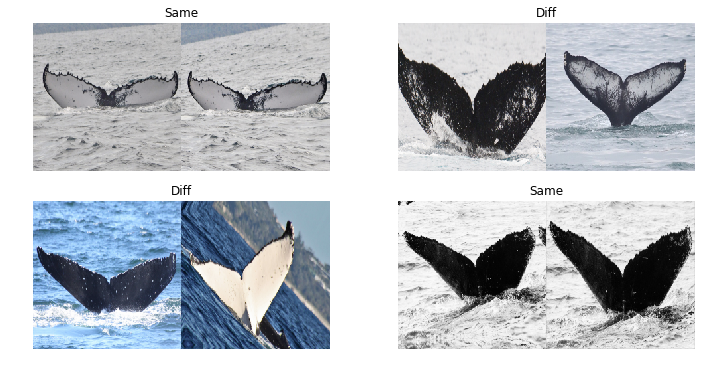

In [15]:
plot_multipair(PairImgDataset(src.train), 2, 2)

In [16]:
trn_dl = DataLoader(PairImgDataset(src.train),
                    batch_size=bs,
                    shuffle=True,
                    num_workers=num_workers)
valid_dl = DataLoader(PairImgDataset(src.valid),
                      batch_size=bs,
                      shuffle=True,
                      num_workers=num_workers)

data_bunch = ImageDataBunch(trn_dl, valid_dl)

In [17]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in imagenet_stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [18]:
data_bunch.add_tfm(normalize_batch)

In [19]:
class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet18):
        super(SiameseNetwork, self).__init__()
        self.cnn = create_body(arch, pretrained=True)
        nf = fastai.callbacks.hooks.num_features_model(self.cnn) * 2
        self.fc = create_head(nf, 5)
    
    def forward_once(self, x):
        output = self.cnn(x)
        output = self.fc(output)
        return output
    
    def forward(self, img1, img2):
        output1 = self.forward_once(img1)
        output2 = self.forward_once(img2)
        return output1, output2

Contrastive Loss
$$(1-Y)\frac{1}{2}(D_W)^2 + (Y)\frac{1}{2}\{max(0,m-D_W)\}^2$$

$$D_W = \sqrt{\{G_W(X_1)-G_W(X_2)\}^2}$$

$Y$ is the label for same or different image  
$G_W$ is the output of our network for one image  
$D_W$ euclidean distance

In [23]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()  # just super() is fine?
        self.margin = margin
    
#     def forward(self, output, label):
#         label = label.float()  # convert from tensor long to float
#         euclidean_distance = F.pairwise_distance(output[0], output[1])
#         loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
#                                       (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
#         return loss_contrastive
    
    def forward(self, img1, img2, label):
        label = label.float()  # convert from tensor long to float
        euclidean_distance = F.pairwise_distance(img1, img2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [24]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=ContrastiveLoss())
learn.split([learn.model.cnn[6], learn.model.fc])
learn.freeze()

In [25]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 3-dimensional input of size [3, 224, 224] instead

In [ ]:
pred = learn.get_preds(n_batch=1)

In [ ]:
accuracy_thresh??

In [ ]:
create_cnn??

In [ ]:
arch = models.resnet18
meta = fastai.vision.learner.cnn_config(arch)
body = create_body(arch, pretrained=True)
nf = fastai.callbacks.hooks.num_features_model(body) * 2
head = create_head(nf, 5)
model = nn.Sequential(body, head)
learn2 = Learner(data_bunch, model, loss_func=ContrastiveLoss())
learn2.split(meta['split'])

In [ ]:
learn.split([learn.model.cnn[6], learn.model.fc])

In [ ]:
learn.model.cnn[6]

In [ ]:
learn2.model[0][6]

In [ ]:
learn2.model[1]

In [ ]:
learn2.model

In [ ]:
learn.model.cnn[6]

In [ ]:
learn.freeze()

In [ ]:
fastai.vision.learner._resnet_split??

In [ ]:
meta = cnn_config(arch)

In [ ]:
torch.backends.cudnn.benchmark??

In [ ]:
create_body??

In [ ]:
tmp_cnn = create_body(models.resnet34)

In [ ]:
type(tmp_cnn)

In [ ]:
tmp_cnn

In [ ]:
create_head??

In [ ]:
create_cnn??

In [ ]:
create_head(50,5)